In [1]:
from DataSimulations import simulate
from Data import DataSet
from Models.LSTM_VAR import LSTM_VAR
import logging
import Train
from Train import set_seed
import keras
from HelpComputation import *
from HelpLatex import *
from HelpPlot import *
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Experiment 5: More Complex DGPs

In [2]:
n, p, m = 1000, 4, 3
test = "Experiment5MoreComplexDGP"
dgp_options = ['v', 'vt', 'vs', 'ts', 'vts']

# Run Experiment

In [3]:
for seed in range(0, 10):
    
    models_results = {'metrics':[], 'gradients':[]}

    print('Simulation',seed)
    set_seed(seed)
    # Simulate Data
    simulation = simulate(n, m, p, seed=seed)
    param = simulation['parameters']
    
    for dgp in dgp_options:
        if not 'v' in dgp:
            param['companion_matrix'] = np.zeros(param['companion_matrix'].shape)
        data = simulation[dgp]
        dataset = DataSet(data.values).preprocessing(1, param['p'], 0.8, 0.1, scale=False)

        # LSTM-VAR
        models = {f'LSTM-VAR: DGP={dgp}': LSTM_VAR(m, p=param['p'], units=64, scaler=dataset.scaler)
              }
        for model_name in models:
            print(model_name, end=' ')
            trained_model, model_eval = Train.train_model(model=models[model_name],dataset=dataset, param=param, epochs=200, verbose=2)
            if seed==0:
                # replace : with "" to avoid problems with saving
                trained_model.save(test+'/models/'+model_name.replace(':',''), save_format="tf")
            t1 = model_eval['metrics']
            t1['model'] = model_name
            t1['simulation'] = param['seed']
        
            t2 = model_eval['gradients']
            t2['model'] = model_name
            t2['simulation'] = param['seed']
        
            models_results['metrics'].append(t1)
            models_results['gradients'].append(t2)
    save(pd.concat(models_results['metrics']), f'metrics_sim{seed}', test+'/results')
    save(pd.concat(models_results['gradients']), f'gradients_sim{seed}', test+'/results')

Simulation 0
LSTM-VAR: DGP=v Epoch 1/200
25/25 - 3s - loss: 1.8065 - val_loss: 1.4972 - 3s/epoch - 109ms/step
Epoch 2/200
25/25 - 0s - loss: 1.4245 - val_loss: 1.2165 - 180ms/epoch - 7ms/step
Epoch 3/200
25/25 - 0s - loss: 1.2030 - val_loss: 1.0786 - 175ms/epoch - 7ms/step
Epoch 4/200
25/25 - 0s - loss: 1.1001 - val_loss: 1.0243 - 172ms/epoch - 7ms/step
Epoch 5/200
25/25 - 0s - loss: 1.0490 - val_loss: 0.9986 - 174ms/epoch - 7ms/step
Epoch 6/200
25/25 - 0s - loss: 1.0177 - val_loss: 0.9809 - 171ms/epoch - 7ms/step
Epoch 7/200
25/25 - 0s - loss: 0.9967 - val_loss: 0.9724 - 174ms/epoch - 7ms/step
Epoch 8/200
25/25 - 0s - loss: 0.9819 - val_loss: 0.9655 - 179ms/epoch - 7ms/step
Epoch 9/200
25/25 - 0s - loss: 0.9707 - val_loss: 0.9590 - 181ms/epoch - 7ms/step
Epoch 10/200
25/25 - 0s - loss: 0.9634 - val_loss: 0.9572 - 183ms/epoch - 7ms/step
Epoch 11/200
25/25 - 0s - loss: 0.9580 - val_loss: 0.9565 - 176ms/epoch - 7ms/step
Epoch 12/200
25/25 - 0s - loss: 0.9537 - val_loss: 0.9556 - 173ms/ep

# Plotting

In [3]:
# TODO Remember to change based on experiment
vars = []
lstm_vars = [f'LSTM-VAR: DGP={m}' for m in dgp_options]
counterparts = vars # can be list of lists if true model is known

In [4]:
order = vars + lstm_vars
palette = sns.color_palette("Set1", n_colors=len(order))
metrics = rename_columns(pd.concat([pd.read_csv(test+'/results/'+file) for file in os.listdir(test+'/results') if 'metrics_sim' in file]).reset_index(drop=True))
gradients = rename_variables(rename_columns(pd.concat([pd.read_csv(test+'/results/'+file) for file in os.listdir(test+'/results') if 'gradients_sim' in file]).reset_index(drop=True)))

## Performance over epochs

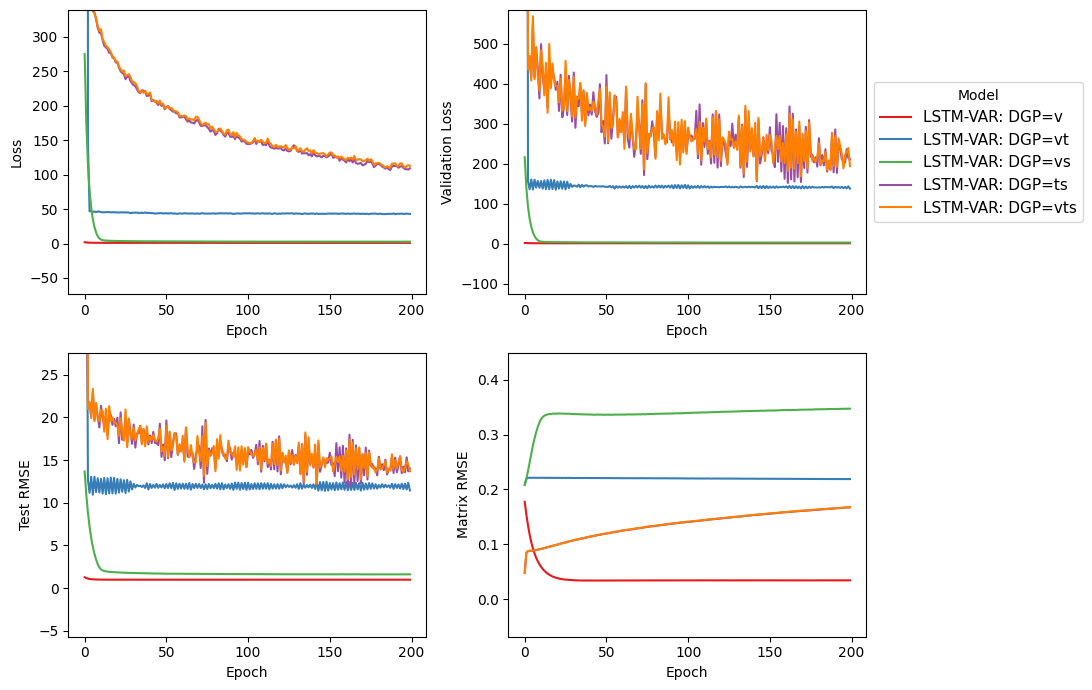

In [7]:
# 1. 2x2 metrics over epochs (exp1-6)
fig = plot_performances_over_epochs(metrics, thresholds=[0.1, 0.1, 0.1, 0.1], palette=palette[:len(lstm_vars)])
fig.savefig(test+'/epochs.png')

# Evolution of the loss, validation loss, test RMSE and matrix RMSE over Epochs

In [8]:
metrics.groupby(['Model', 'Epoch']).mean()[['Validation Loss', 'Matrix RMSE', 'Test RMSE',  'Same Sign %']].reset_index().groupby(['Model']).min().reindex(lstm_vars)

,Epoch,Validation Loss,Matrix RMSE,Test RMSE,Same Sign %
Model,,,,,
LSTM-VAR: DGP=v,0,0.956638,0.033948,0.983991,0.733333
LSTM-VAR: DGP=vt,0,134.906244,0.208763,10.940417,0.488889
LSTM-VAR: DGP=vs,0,2.703497,0.208003,1.602013,0.491667
LSTM-VAR: DGP=ts,0,151.678515,0.048315,11.811467,0.383333
LSTM-VAR: DGP=vts,0,158.865424,0.047857,12.208840,0.408333


## Gradient analysis
Kernel = what handles the X
Reccurent Kernel = what handles the cell state

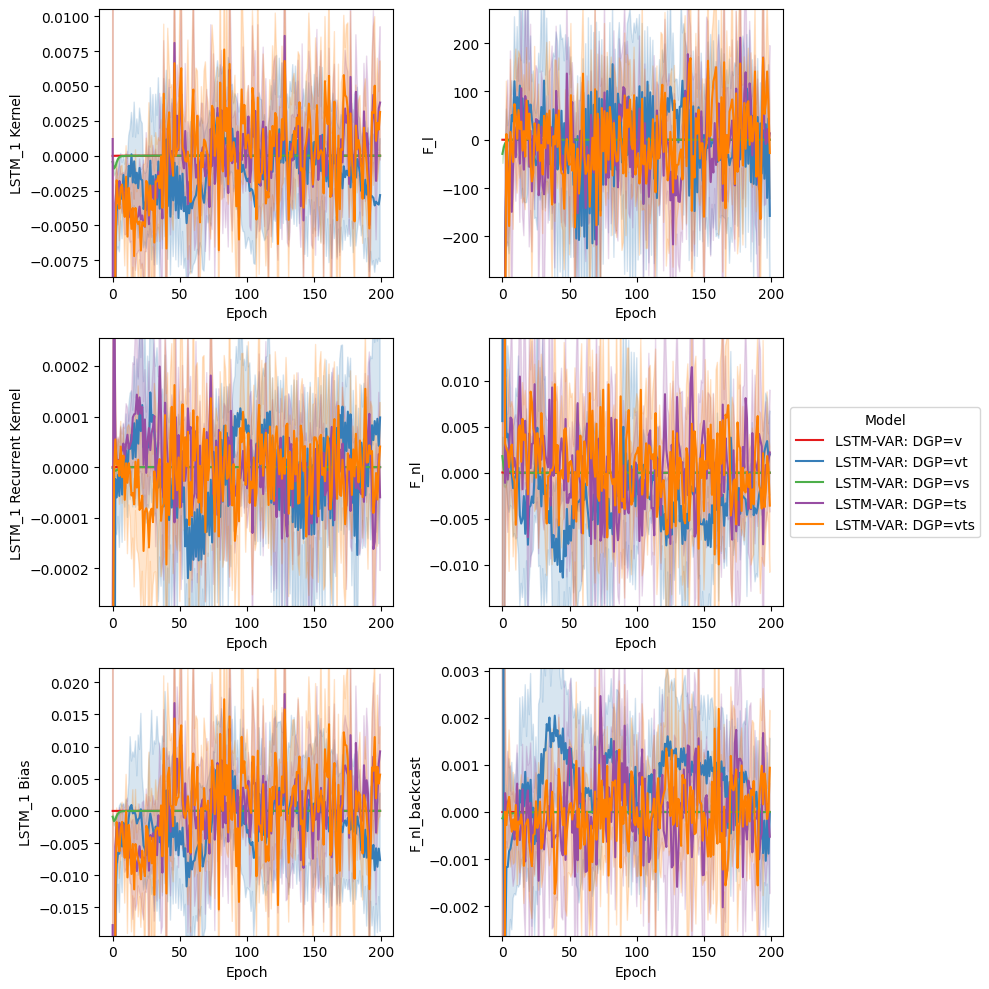

In [9]:
# 2. Gradient over epochs (exp5)
fig = plot_gradients_over_epochs(gradients, palette[:len(lstm_vars)])
fig.savefig(test+'/gradients.png')

# Evolution of Gradients with Standard Deviation

## Convergence analysis
Table with mean (std), % difference (std) for matrix and val loss.

In [10]:
# 3. Convergence table (exp1)
converge = compute_convergence(metrics)
table = converge_to_latex_table(converge, lstm_vars)
print(table.style.to_latex())
# Convergence Metrics and Relative Change Across LSTM-VAR Models

Means: Validation Convergence  mean    38.620
                        std     17.414
Matrix Convergence      mean    16.460
                        std      3.808
Ratio                   mean     0.636
                        std      0.246
dtype: float64
\begin{tabular}{llll}
 & Validation Convergence & Matrix Convergence & Ratio \\
Model &  &  &  \\
LSTM-VAR: DGP=v & 26.6 (6.59) & 46.3 (19.04) & 1.76 (0.69) \\
LSTM-VAR: DGP=vt & 24.5 (18.14) & 9.0 (0.0) & 0.47 (0.17) \\
LSTM-VAR: DGP=vs & 88.8 (31.79) & 9.0 (0.0) & 0.11 (0.03) \\
LSTM-VAR: DGP=ts & 27.0 (15.98) & 9.0 (0.0) & 0.42 (0.17) \\
LSTM-VAR: DGP=vts & 26.2 (14.57) & 9.0 (0.0) & 0.42 (0.17) \\
\end{tabular}


Statistical test to see if the relative change between convergences is significantly different between models

In [11]:
# 4. Convergence differences statistical test (exp1)
groups = converge.groupby('Simulation')['Ratio'].apply(lambda x: x.dropna().values).tolist()
f_statistic, p_value = stats.f_oneway(*groups)
print('Between simulations')
print(f"P-value: {p_value}", f"--- F-statistic: {f_statistic}")

groups = converge.groupby('Model')['Ratio'].apply(lambda x: x.dropna().values).tolist()
f_statistic, p_value = stats.f_oneway(*groups)
print('Between models')
print(f"P-value: {p_value}", f"--- F-statistic: {f_statistic}")
print('Ratio Q3:', converge['Ratio'].quantile(0.90))

Between simulations
P-value: 0.9624651201526969 --- F-statistic: 0.3230350843332052
Between models
P-value: 1.1192148037613456e-13 --- F-statistic: 36.92345442900424
Ratio Q3: 1.6248847926267282


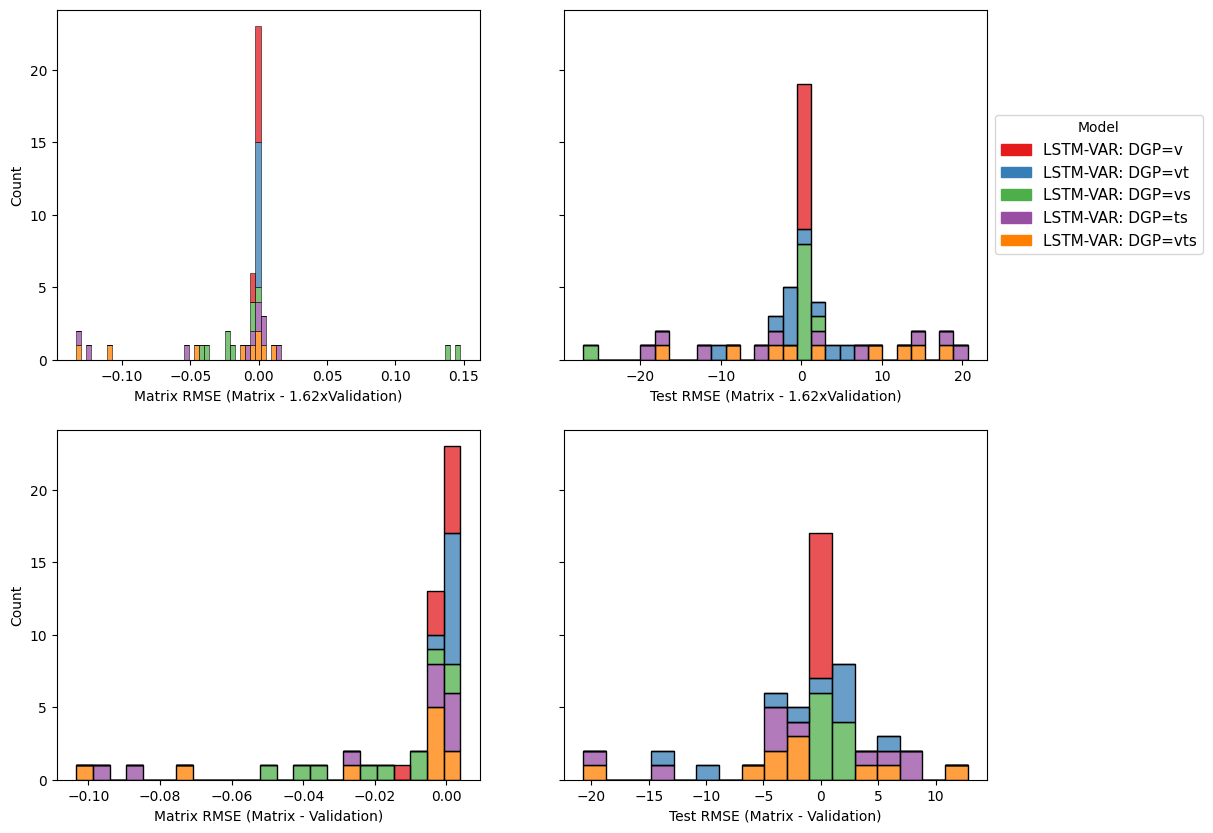

In [12]:
# 5. Convergence metric differences histogram
q3 = np.round(converge['Ratio'].quantile(0.90), 2)
est = get_converged(metrics, converge.set_index(['Model', 'Simulation'])['Validation Convergence']*q3, lstm_vars) # Using Q3 of ratio
mat = get_converged(metrics, converge.set_index(['Model', 'Simulation'])['Matrix Convergence'], lstm_vars)
val = get_converged(metrics, converge.set_index(['Model', 'Simulation'])['Validation Convergence'], lstm_vars)

# Difference between matrix and estimated convergence and between matrix and validation convergence
test_diff = mat[['Matrix RMSE', 'Test RMSE', 'Model', 'Simulation']].reset_index(drop=True)
test_diff.loc[:, f'Test RMSE (Matrix - {q3}xValidation)'] = test_diff['Test RMSE'] - est['Test RMSE']
test_diff.loc[:, f'Matrix RMSE (Matrix - {q3}xValidation)'] = test_diff['Matrix RMSE'] - est['Matrix RMSE']
test_diff.loc[:, 'Test RMSE (Matrix - Validation)'] = test_diff['Test RMSE'] - val['Test RMSE']
test_diff.loc[:, 'Matrix RMSE (Matrix - Validation)'] = test_diff['Matrix RMSE'] - val['Matrix RMSE']
# Re-order
min_diff = order_df((est.sort_values(by=['Model', 'Simulation']).set_index(['Model','Simulation'])[['Matrix RMSE', 'Test RMSE']] - metrics.groupby(['Model', 'Simulation']).min()[['Matrix RMSE', 'Test RMSE']]).reset_index(), lstm_vars)

fig = plot_convergence_differences(
    [{'df':[test_diff, test_diff], 'columns':[f'Matrix RMSE (Matrix - {q3}xValidation)', f'Test RMSE (Matrix - {q3}xValidation)'], 'hue':'Model', 'legend':True, 'palette': palette[:len(lstm_vars)]},
     {'df':[test_diff, test_diff], 'columns':['Matrix RMSE (Matrix - Validation)', 'Test RMSE (Matrix - Validation)'], 'hue':'Model', 'legend':False, 'palette': palette[:len(lstm_vars)]}])
fig.savefig(test+'/convdiff.png')

# Histograms of Differences in Convergence Metrics

In [13]:
print(test_diff.describe()[['Matrix RMSE (Matrix - Validation)', f'Matrix RMSE (Matrix - {q3}xValidation)', 'Test RMSE (Matrix - Validation)', f'Test RMSE (Matrix - {q3}xValidation)']].loc[['min','max']])

     Matrix RMSE (Matrix - Validation)  \
min                          -0.103429   
max                           0.003916   

     Matrix RMSE (Matrix - 1.62xValidation)  Test RMSE (Matrix - Validation)  \
min                               -0.133486                       -20.688294   
max                                0.147568                        12.794836   

     Test RMSE (Matrix - 1.62xValidation)  
min                            -27.075061  
max                             20.656905  


## Convergence results

Table of model, matrix sim, test mse (mean (std)), % difference
Table of statistical tests
Heatmap or joyplot plot of variable and lag eucl dist (2 parts)

In [17]:
# 6. Results table (exp1-6)
results = pd.concat([val.drop(columns=['Loss', 'Validation Loss', 'Epoch'])])
table = results_to_latex_table(results, lstm_vars, vars)
print(table[['Matrix RMSE', 'Test RMSE', 'Same Sign %']].style.to_latex())
# Performance of LSTM-VAR Models and VAR Models

\begin{tabular}{llll}
 & Matrix RMSE & Test RMSE & Same Sign % \\
 & Mean & Mean & Mean \\
Model &  &  &  \\
LSTM-VAR: DGP=v & 0.034 (0.005) & 0.983 (0.057) & 0.933 (0.049) \\
LSTM-VAR: DGP=vt & 0.221 (0.046) & 12.798 (6.139) & 0.492 (0.083) \\
LSTM-VAR: DGP=vs & 0.339 (0.065) & 1.63 (0.211) & 0.661 (0.09) \\
LSTM-VAR: DGP=ts & 0.113 (0.044) & 21.116 (11.754) & 0.397 (0.104) \\
LSTM-VAR: DGP=vts & 0.113 (0.041) & 21.103 (10.634) & 0.422 (0.094) \\
\end{tabular}


In [15]:
# 7. Results p-values table (exp1-6)
####### NOT APPLICABLE FOR THIS EXPERIMENT #######

#table = compute_p_values(results, lstm_vars, counterparts)

#print(table[['Matrix RMSE', 'Test RMSE']].style.to_latex())
#print(table[['Same Sign %']].style.to_latex())
# Statistical Test Results for LSTM-VAR Models vs. VAR Model

## Variable-wise and lag-wise RMSE

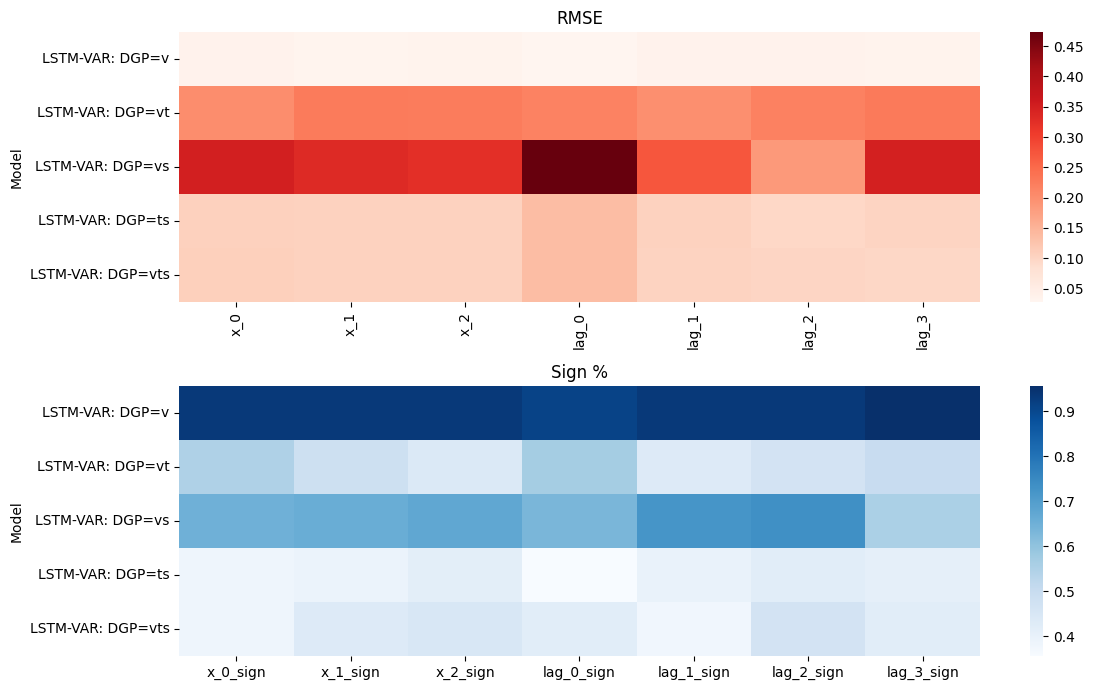

In [16]:
# 8. Variable wise and lag wise heatmap (exp2-5)
fig = plot_heatmap(results, vars, lstm_vars)
fig.savefig(test+'/lags_n_vars.png')

## Forecast breakdown

In [18]:
# 9. Breakdown of forecasts (exp5-6)

# Read all models in test/models
models = {file:keras.models.load_model(test+'/models/'+file) for file in os.listdir(test+'/models')}
print(models.keys())

dict_keys(['LSTM-VAR DGP=ts', 'LSTM-VAR DGP=v', 'LSTM-VAR DGP=vs', 'LSTM-VAR DGP=vt', 'LSTM-VAR DGP=vts'])


In [33]:
# TODO Pick model and what you want to plot
model = models['LSTM-VAR DGP=vs']
dgp = 'vs' # v, t, s, vt, vs, ts, vts
time_series = 0 # 0 to m-1

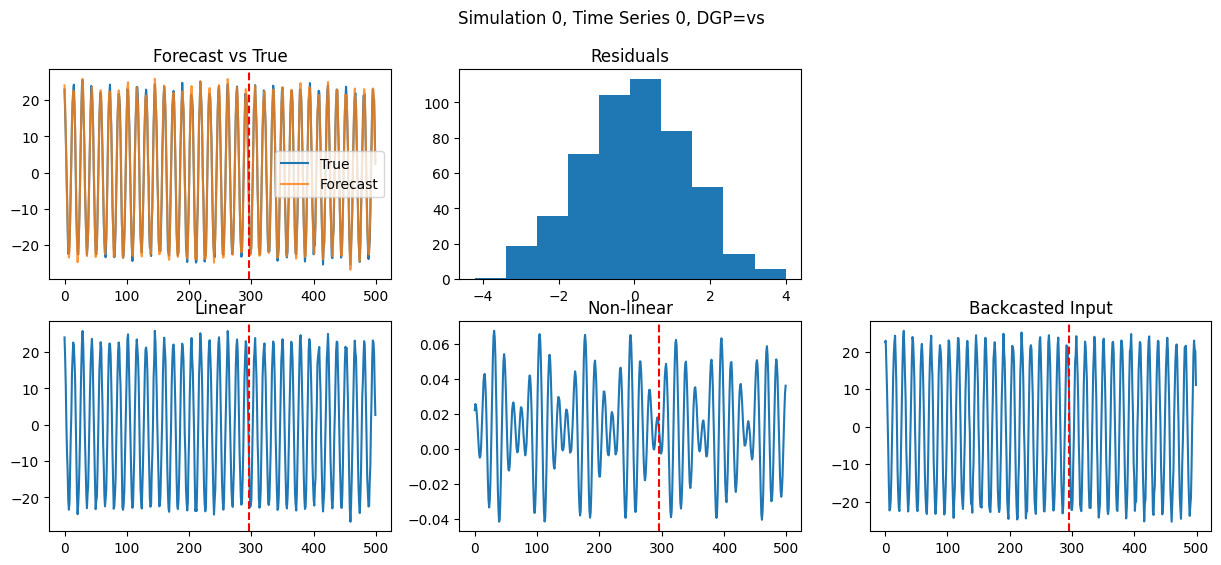

In [34]:
input_window = 4 # depends on model
simulation = simulate(time_steps=1000, m=3, p=4, seed=0)
dataset = DataSet(simulation[dgp].values).preprocessing(1, input_window, 0.8, 0.1, scale=False)
fig = plot_forecast_breakdown(model, dataset, time_series, dgp)